# Understanding the decoding framework

This notebooks takes you through the `TimeDecoding` and `GeneralizationAcrossTime` objects, so as to understand how a simple classifier can be fitted and used to make predictions at each time sample in a cross validation scheme.

# Prepare data


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mne import EpochsArray
from mne.io.meas_info import create_info
from mne.decoding import TimeDecoding, GeneralizationAcrossTime

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

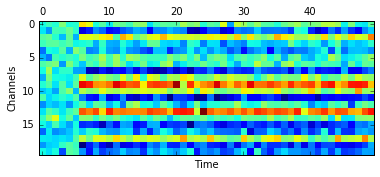

In [2]:
# Simulate an MEG epoch dataset for a given subject. 
n_trial, n_chan, n_time = 100, 20, 50

# The convention in machine learning is that we're looking for a a function `f` so that `f(X) = y`.
# Here `X` is the MEG data, `y` is the experimental condition and `f` will be linear.
X = np.ones((n_trial, n_chan, n_time))

# We'll start with a categorical `y` (e.g. present versus absent trials):
y = np.random.randint(0, 2, n_trial)

# Add information on a third of the channels so that `X` encodes `y`.
# -- Define a unique coding topography
coding_chan = np.random.randn(n_chan)
# --- Define coding times
coding_time = np.arange(n_time) > 5
codes = np.transpose([encode * coding_chan for encode in coding_time])
# --- Add information to trials where `y==1`:
codes = np.array([trial * codes for trial in y])
X += codes

# Add common activity to all trials
common_activity = np.random.randn(n_chan, n_time)
X += np.tile(common_activity, [n_trial, 1, 1])

# Add background noise
snr = .5
X += np.random.randn(*X.shape) / snr

# Plot mean difference across conditions
fig, ax = plt.subplots(1)
ax.matshow(X[y==0].mean(0) - X[y==1].mean(0))
ax.set_xlabel('Time')
ax.set_ylabel('Channels')
plt.show()

# Decoding

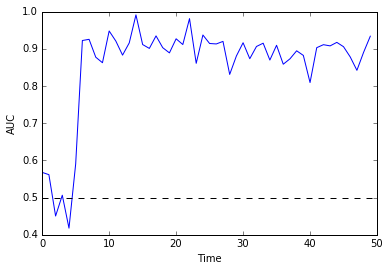

In [3]:
# Let's define a linear SVM classifier. To optimize the result, we use 
#     i) a normalization step,
#     ii) a probabilistic output.
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# As the output is continuous and not discrete, the scoring metrics is an Area Under the Curve.
# Note: scikit-learn doesn't score probabilistic estimates by default, so we're building it ourself.

def scorer(y_true, y_pred):
    # Probabilistic estimates are reported for each class. In our case 
    # `y_pred` shape is (n_trials, 2), where `y[:, 0] = 1 - y[:, 1]`.
    return roc_auc_score(y_true, y_pred[:, 1])

# To avoid over-fitting we have to use a cross-validation procedure. Since it is 
# a classification problem, it's better to use stratified folding
cv = StratifiedKFold()

# Let's train and test a classifier at each time sample
scores = []
for time in range(n_time):
    score_cv = []
    y_pred = np.zeros((n_trial, 2))  # Probabilistic estimates are reported for each class, hence n = 2
    for train, test in cv.split(X=X, y=y):
        # Fit on train set
        clf.fit(X[train, :, time], y[train])
        # Predict on test set
        y_pred[test, :] = clf.predict_proba(X[test, :, time])
    # Score across all predictions.
    # Note that in Machine Learning, we usually score per fold to estimate the variance across folds. 
    # Since we won't do any statistics within subjects, but only across subjects, we can directly concatenate
    # the folds. 
    score = scorer(y, y_pred)
    scores.append(score)

# Plot
fig, ax = plt.subplots(1)
ax.plot(scores)
ax.set_xlabel('Time')
ax.set_ylabel('AUC')
ax.axhline(.5, color='k', linestyle='--')
plt.show()    

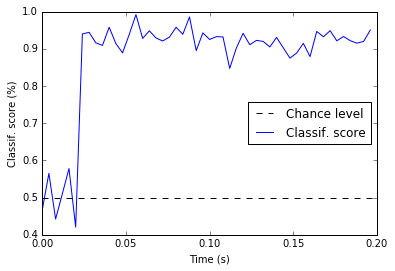

In [4]:
# This decoding pipeline has now been integrated in MNE-Python.
# The corresponding code is more complex to optimize speed and memory

# Format MEG data into MNE-Python object
events = np.vstack((range(n_trial), np.zeros(n_trial, int), y)).T
chan_names = ['MEG %i' % chan for chan in range(n_chan)]
chan_types = ['mag'] * n_chan
sfreq = 250
info = create_info(chan_names, sfreq, chan_types)
epochs = EpochsArray(data=X, info=info, events=events, verbose=False)

# Decoding
td = TimeDecoding(scorer=scorer, cv=cv, predict_method='predict_proba')
td.fit(epochs, y=y)
td.score(epochs, y=y)
td.plot(chance=.5)
plt.show()

# Generalization across time

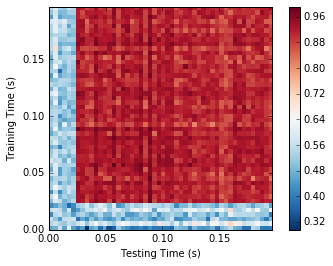

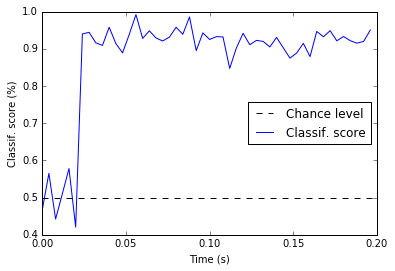

In [5]:
# The generalization across time is very similar, except that we predict and score each estimator at all time points.
# This is achieved with the GeneralizationAcrossTime object
gat = GeneralizationAcrossTime(scorer=scorer, cv=cv, predict_method='predict_proba')
gat.fit(epochs, y=y)
gat.score(epochs, y=y)
gat.plot()
gat.plot_diagonal(chance=.5)  # Note that the GAT diagonal corresponds to TimeDecoding
plt.show()